In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# debugging
import pdb;

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def generate_time_series(batch_size, n_steps):
#    pdb.set_trace()
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
freq1, freq2, offsets1, offsets2 = np.random.rand(4, 100, 1)

In [4]:
freq1

array([[0.37454012],
       [0.95071431],
       [0.73199394],
       [0.59865848],
       [0.15601864],
       [0.15599452],
       [0.05808361],
       [0.86617615],
       [0.60111501],
       [0.70807258],
       [0.02058449],
       [0.96990985],
       [0.83244264],
       [0.21233911],
       [0.18182497],
       [0.18340451],
       [0.30424224],
       [0.52475643],
       [0.43194502],
       [0.29122914],
       [0.61185289],
       [0.13949386],
       [0.29214465],
       [0.36636184],
       [0.45606998],
       [0.78517596],
       [0.19967378],
       [0.51423444],
       [0.59241457],
       [0.04645041],
       [0.60754485],
       [0.17052412],
       [0.06505159],
       [0.94888554],
       [0.96563203],
       [0.80839735],
       [0.30461377],
       [0.09767211],
       [0.68423303],
       [0.44015249],
       [0.12203823],
       [0.49517691],
       [0.03438852],
       [0.9093204 ],
       [0.25877998],
       [0.66252228],
       [0.31171108],
       [0.520

In [5]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [6]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


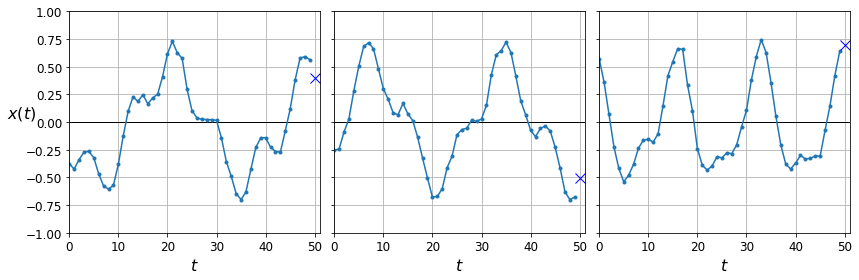

In [7]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

In [8]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

In [9]:
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[50, 1]),
keras.layers.Dense(1)
])

In [10]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

In [11]:
model = keras.models.Sequential([
keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [12]:
model.compile(loss = 'mse',optimizer = 'adam')

In [13]:
model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0604 - val_loss: 0.0509
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0406 - val_loss: 0.0342
Epoch 3/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0270 - val_loss: 0.0226
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0184 - val_loss: 0.0159
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0141 - val_loss: 0.0129
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 7/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 8/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0117 - val_loss: 0.0113
Epoch 9/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0116 - val_lo

In [14]:
# Deep RNN

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 19s 85ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 19s 85ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 19s 86ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 19s 85ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 19s 87ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 19s 85ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 18s 84ms/step - loss: 0.003

In [15]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis,:]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]


In [16]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


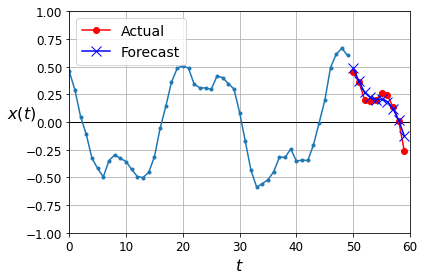

In [17]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

In [18]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]


In [19]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])


In [20]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0591 - val_loss: 0.0336
Epoch 2/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0304 - val_loss: 0.0250
Epoch 3/20
219/219 [==============================] - 13s 57ms/step - loss: 0.0216 - val_loss: 0.0171
Epoch 4/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0156 - val_loss: 0.0141
Epoch 5/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0130 - val_loss: 0.0115
Epoch 6/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0124 - val_loss: 0.0108
Epoch 7/20
219/219 [==============================] - 12s 57ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 8/20
219/219 [==============================] - 13s 57ms/step - loss: 0.0108 - val_loss: 0.0094
Epoch 9/20
219/219 [==============================] - 12s 57ms/step - loss: 0.0100 - val_loss: 0.0110
Epoch 10/20
219/219 [==============================] - 12s 57ms/step - loss: 0.009

In [21]:
Y_pred = model.predict(X_new)

In [22]:
Y_new.reshape(1,10)

array([[ 0.4540791 ,  0.36484516,  0.20194076,  0.19345327,  0.20350602,
         0.25884628,  0.24583101,  0.13509367,  0.01122888, -0.26238245]],
      dtype=float32)

In [23]:
Y_pred

array([[ 0.4780925 ,  0.3061157 ,  0.19369315,  0.11212197,  0.13127159,
         0.16462283,  0.21366712,  0.1617378 ,  0.05838498, -0.13156432]],
      dtype=float32)

In [24]:
np.mean(keras.metrics.mean_squared_error(Y_new.reshape(1,10), Y_pred))

0.0045885975

In [25]:
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [26]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [27]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0523 - last_time_step_mse: 0.0413 - val_loss: 0.0426 - val_last_time_step_mse: 0.0312
Epoch 2/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0400 - last_time_step_mse: 0.0286 - val_loss: 0.0368 - val_last_time_step_mse: 0.0270
Epoch 3/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0324 - last_time_step_mse: 0.0208 - val_loss: 0.0292 - val_last_time_step_mse: 0.0171
Epoch 4/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0297 - last_time_step_mse: 0.0182 - val_loss: 0.0277 - val_last_time_step_mse: 0.0167
Epoch 5/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0277 - last_time_step_mse: 0.0164 - val_loss: 0.0301 - val_last_time_step_mse: 0.0201
Epoch 6/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0256 - last_time_step_mse: 0.0136 - val_loss: 0.0228 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/2

In [28]:
Y_pred1 = model.predict(X_new)

In [29]:
Y_pred1[:,-1,:]

array([[ 0.4646397 ,  0.30996835,  0.18490548,  0.1267254 ,  0.13503191,
         0.1698383 ,  0.19049147,  0.16189313,  0.06310359, -0.09679893]],
      dtype=float32)

In [30]:
np.mean(keras.metrics.mean_squared_error(Y_new.reshape(1,10), Y_pred1[:,-1,:]))

0.0054366486

In [31]:
# Fighting the Unstable Gradients Problem

In [32]:

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]